In [1]:
import os 
os.chdir('../../../../')
print("Current working directory is now: ", os.getcwd())

import pandas as pd 
import numpy as np
import csv
import utils.baseline_functions as base
import stumps
import RiskSLIM as slim

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import roc_auc_score

# restore saved variables
%store -r summary_drug2_KY_interpret

Current working directory is now:  C:\Users\binha\Documents\Duke\Cynthia Research\psa-analysis - test
no stored variable summary_drug2_KY_interpret


C:\Users\binha\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).



### CART & EBM

In [2]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
data = data.drop(['fta_risk_score_raw','nca_risk_score_raw','pvf_risk_score_raw', 
                  'fta_calc', 'nca_calc', 'pvf_calc'], axis=1)
x = data.loc[:,:'current_violence']
y = data['recid_drug_two_year'].values

In [3]:
#### CART
depth = [7,8,9]
cart_summary = base.CART(X=x,
                         Y=y,
                         depth=depth,
                         seed=816)

#### EBM
estimators = [20]
depth = [2]
learning_rate = [0.5]
ebm_summary = base.EBM(X=x,
                       Y=y,
                       learning_rate=learning_rate,
                       depth=depth,
                       estimators=estimators,
                       seed =816)

model_id, score_thresholds 0 {'rank_abs': [68]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [26]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [46]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [13]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [11]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [20]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [15]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [37]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [18]}
get_disparity_predefined_group()


model_id, score_thresholds 0 {'rank_abs': [17]}
get_disparity_predefined_group()


In [4]:
np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])

(0.6949277402624676, 0.016876619145890427)

In [6]:
np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])

(0.7014736549700928, 0.007181449117447359)

### Lasso Stumps

In [7]:
## load whole data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
X_stumps, Y_stumps = data.loc[:,:'current_violence>=1'], data['recid_drug_two_year'].values
Y_stumps[Y_stumps == -1] = 0
cols = X_stumps.columns[3:]

## load train & test data
train_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_train_stumps.csv")
test_stumps = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_test_stumps.csv")

X_train_stumps, Y_train_stumps = train_stumps.loc[:,:'current_violence>=1'], train_stumps['recid_drug_two_year'].values
X_test_stumps, Y_test_stumps = test_stumps.loc[:,:'current_violence>=1'], test_stumps['recid_drug_two_year'].values

Y_train_stumps[Y_train_stumps == -1] = 0
Y_test_stumps[Y_test_stumps == -1] = 0

In [8]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.007, 0.005, 0.003]}, 
                                seed = 816)

model_id, score_thresholds 0 {'rank_abs': [16451]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [15466]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [15131]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [14883]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [15805]}
get_disparity_predefined_group()


In [9]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

([{'C': 0.007}, {'C': 0.007}, {'C': 0.007}, {'C': 0.007}, {'C': 0.007}],
 0.69931057367503,
 0.0012430422597720981)

##### Best Stump Model

In [14]:
best_stump_model = stumps.stump_model(X_train_stumps, Y_train_stumps, 
                                      X_test_stumps, Y_test_stumps, 
                                      c=0.003, columns=cols, seed=816)

##### Prediction Table

In [15]:
stumps.stump_table(best_stump_model['coefs'], 
                   best_stump_model['features'], 
                   best_stump_model['intercept'], 
                   best_stump_model['dictionary'])

+-----------------------------------+----------------+
| Features                          | Score          |
|====================================================|
| sex                               | 4.4            |
| age_at_current_charge<=43         | 8.5            |
| p_arrest>=1                       | -28.2          |
| p_arrest>=2                       | 39.2           |
| p_arrest>=3                       | 27.4           |
| p_arrest>=4                       | 7.5            |
| p_arrest>=5                       | 13.4           |
| p_arrest>=6                       | 8.0            |
| p_charges>=1                      | -31.5          |
| p_felony>=2                       | -3.3           |
| p_misdemeanor>=1                  | 3.8            |
| p_misdemeanor>=2                  | 4.6            |
| p_misdemeanor>=3                  | 4.4            |
| p_drug>=1                         | 61.5           |
| p_drug>=2                         | 8.2            |
| p_steali

In [16]:
stump_summary = stumps.stump_cv(X = X_stumps, 
                                Y = Y_stumps, 
                                columns=cols, 
                                c_grid={'C': [0.003]}, 
                                seed = 816)

model_id, score_thresholds 0 {'rank_abs': [14924]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [14988]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [14327]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [14277]}
get_disparity_predefined_group()
model_id, score_thresholds 0 {'rank_abs': [14988]}
get_disparity_predefined_group()


In [17]:
stump_summary['best_params'], np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])

([{'C': 0.003}, {'C': 0.003}, {'C': 0.003}, {'C': 0.003}, {'C': 0.003}],
 0.6966815902686664,
 0.0008163942945702107)

##### Stumps Visualizations

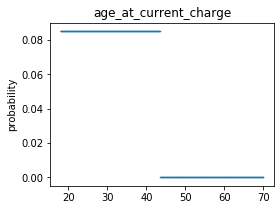

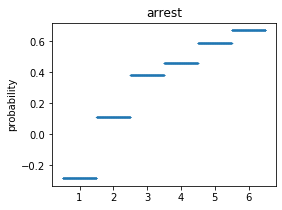

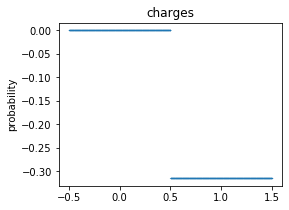

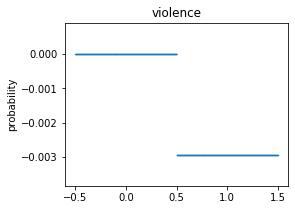

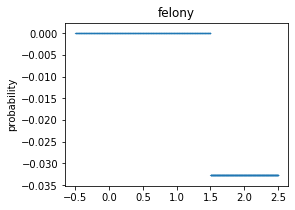

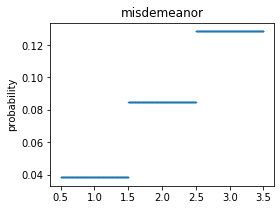

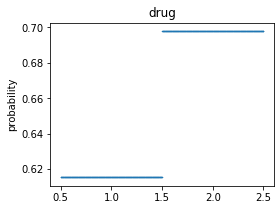

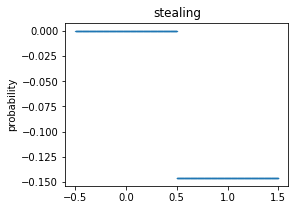

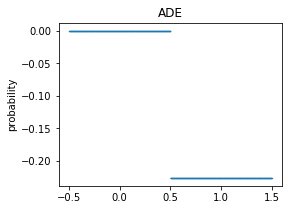

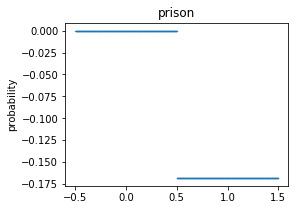

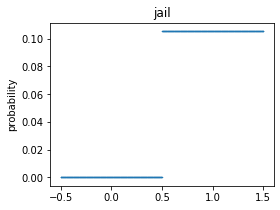

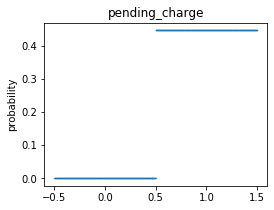

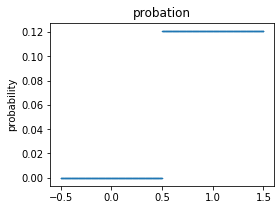

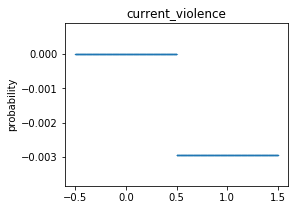

In [18]:
stumps.stump_plots(best_stump_model['features'], best_stump_model['coefs'])

### Arnold PSA

In [19]:
### load data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_data.csv")
X_arnold_raw = data['nca_risk_score_raw'].values
X_arnold_calc = data['nca_calc'].values
Y_arnold = data['recid_drug_two_year'].values

In [20]:
## set up cross validation
cv = KFold(n_splits=5,shuffle=True,random_state=816)
raw_auc = []
calc_auc = []

## raw score
i = 1
for train, test in cv.split(X_arnold_raw, Y_arnold):
    y_pred_raw, y_pred_calc, y_test = X_arnold_raw[test], X_arnold_calc[test], Y_arnold[test]
    raw_auc.append(roc_auc_score(y_test, y_pred_raw))
    calc_auc.append(roc_auc_score(y_test, y_pred_calc))
    i+=1 

## RiskSLIM

In [21]:
## load stumps data
data = pd.read_csv("~/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY data/kentucky_stumps.csv")
x, y = data.loc[:,:'current_violence>=1'], data['recid_drug_two_year'].values
cols = x.columns[3:]

In [22]:
## train on best param chosen by Lasso Stumps from above
x_train = x.copy().drop(['race', 'person_id', 'screening_date'], axis=1)
lasso = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l1', C=0.003, random_state=816).fit(x_train,y)
selected_features = cols[lasso.coef_[0] != 0].tolist()
len(selected_features)

24

In [23]:
### Subset features
if 'sex' in selected_features:
    selected_features = ['recid_drug_two_year', 'person_id', 'screening_date', 'race'] + selected_features
    indicator = 1
else:
    selected_features = ['recid_drug_two_year', 'person_id', 'screening_date', 'race', 'sex'] + selected_features
    indicator = 0

sub_data = data[selected_features]
sub_X, sub_Y = sub_data.iloc[:,1:], sub_data.iloc[:,0].values
sub_X.insert(0, '(Intercept)', 1)

In [24]:
riskslim_summary = slim.risk_cv(X=sub_X, 
                                Y=sub_Y, 
                                indicator = indicator,
                                y_label='drug2', 
                                max_coef=20, 
                                max_coef_number=10, 
                                max_runtime=200, 
                                c=1e-8, 
                                seed=816)

setting c0 = 0.0 to ensure that intercept is not penalized
09/11/19 @ 12:38 AM | 1061 rows in lookup table
09/11/19 @ 12:38 AM | ------------------------------------------------------------
09/11/19 @ 12:38 AM | runnning initialization procedure
09/11/19 @ 12:38 AM | ------------------------------------------------------------
09/11/19 @ 12:38 AM | CPA produced 2 cuts
09/11/19 @ 12:38 AM | running naive rounding on 58 solutions
09/11/19 @ 12:38 AM | best objective value: 0.2812
09/11/19 @ 12:38 AM | rounding produced 5 integer solutions
09/11/19 @ 12:38 AM | best objective value is 0.2907
09/11/19 @ 12:38 AM | running sequential rounding on 58 solutions
09/11/19 @ 12:38 AM | best objective value: 0.2812
09/11/19 @ 12:39 AM | sequential rounding produced 6 integer solutions
09/11/19 @ 12:39 AM | best objective value: 0.2881
09/11/19 @ 12:39 AM | polishing 11 solutions
09/11/19 @ 12:39 AM | best objective value: 0.2881
09/11/19 @ 12:39 AM | polishing produced 5 integer solutions
09/11/19

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 12:39 AM | adding 239 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.2878.
Tried aggregator 1 time.
Reduced MIP has 26 rows, 52 columns, and 99 nonzeros.
Reduced MIP has 24 binaries, 26 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.02 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

 177420 53477        cutoff              0.2861        0.2797   949717    2.23%          rho_13 U 177420 177419     47
 181686 54543        cutoff              0.2861        0.2797   967881    2.23%          rho_11 D 181686 181685     57
 185560 54962        0.2806    10        0.2861        0.2798   986480    2.22%           rho_3 D 185560 185559     22
 189520 55374        0.2839    13        0.2861        0.2798  1002408    2.20%           rho_5 D 189520 189519     42
 193902 56456        0.2800    11        0.2861        0.2798  1017552    2.19%          rho_12 D 193902 105280     56
 197527 57475        cutoff              0.2861        0.2799  1035436    2.16%           rho_3 U 197527 140853     62
 201518 57675        0.2800    12        0.2861        0.2800  1051723    2.15%          rho_10 U 201518 201516     37
 205468 59326        0.2801    11        0.2861        0.2800  1068264    2.14%           rho_5 D 205468  63750     39
Elapsed time = 35.53 sec. (50796.36 ticks, tree 

 619408 103905        0.2842     9        0.2861        0.2828  2910970    1.17%           rho_3 D 619408 619406     59
 633490 102047        0.2832     9        0.2861        0.2829  2974358    1.13%          rho_20 D 633490 633488     74
 647954 100910        cutoff              0.2861        0.2830  3033755    1.10%           rho_0 U 647954 647953     57
 662075 100846        0.2846     9        0.2861        0.2831  3101124    1.07%          rho_13 D 662075 662074     31
Elapsed time = 129.00 sec. (168110.29 ticks, tree = 28.96 MB, solutions = 2)
 676833 100479        0.2838     7        0.2861        0.2831  3158700    1.04%           rho_6 N 676833 130225     61
 691384 99670        cutoff              0.2861        0.2832  3219138    1.01%          rho_24 D 691384 691382     73
 706280 99874        0.2855     3        0.2861        0.2833  3281311    0.99%          rho_22 D 706280 706279     24
 720661 99945        0.2834    13        0.2861        0.2834  3343064    0.96%      

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 12:42 AM | adding 210 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.2880.
Tried aggregator 1 time.
Reduced MIP has 26 rows, 52 columns, and 99 nonzeros.
Reduced MIP has 24 binaries, 26 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

 205166 66266        0.2831    10        0.2880        0.2819  1153001    2.13%           rho_3 U 205166 193959     32
 210466 67671        0.2846    11        0.2880        0.2819  1173476    2.12%           rho_6 D 210466 210465     73
 215700 68864        0.2878     6        0.2880        0.2819  1191565    2.12%           rho_9 N 215700 215698     25
 220309 69514        0.2879     5        0.2880        0.2819  1210515    2.11%          rho_20 D 220309 220307     51
 224916 70375        0.2843     9        0.2880        0.2820  1230494    2.10%           rho_2 N 224916 194828     37
 228968 70362        cutoff              0.2880        0.2820  1254488    2.10%           rho_2 U 228968 161209     64
 233223 70449        0.2869    13        0.2880        0.2820  1276011    2.08%           rho_6 D 233223 233222     44
 237413 71355        0.2827    12        0.2880        0.2821  1296472    2.07%          rho_22 D 237413 237412     36
Elapsed time = 38.16 sec. (50795.41 ticks, tree 

 730588 120349        0.2866    11        0.2880        0.2847  3480448    1.15%           rho_6 D 730588 730587     36
 746992 119770        0.2873     7        0.2880        0.2848  3552387    1.13%           rho_6 D 746992 746990     29
 764201 119235        0.2876     7        0.2880        0.2848  3621949    1.11%          rho_23 D 764201 764199     80
 781140 115612        0.2852    11        0.2880        0.2850  3706999    1.06%           rho_1 D 781140 781138     58
Elapsed time = 128.22 sec. (168106.68 ticks, tree = 31.61 MB, solutions = 3)
 799732 117286        0.2854    12        0.2880        0.2850  3775350    1.04%          rho_12 D 799732 738576     51
 815661 114145        cutoff              0.2880        0.2852  3858868    1.00%          rho_14 U 815661  27779     54
 835428 110339        0.2855     7        0.2880        0.2853  3935301    0.95%           rho_9 N 835428 754734     55
 853811 108435        0.2859    18        0.2880        0.2854  4004653    0.91%   

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 12:45 AM | adding 238 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.2859.
Tried aggregator 1 time.
Reduced MIP has 26 rows, 52 columns, and 99 nonzeros.
Reduced MIP has 24 binaries, 26 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

 179924 55215        cutoff              0.2845        0.2779   931607    2.32%           rho_2 U 179924 168071     30
 183539 56516        0.2795     9        0.2845        0.2779   950892    2.32%          rho_12 D 183539 183538     49
 187000 57781        0.2831     7        0.2845        0.2779   974953    2.32%           rho_7 D 187000 186999     50
 190687 59265        0.2834     7        0.2845        0.2779   993684    2.32%           rho_1 D 190687 190686     75
 194444 60394        cutoff              0.2845        0.2779  1011887    2.32%          rho_22 U 194444 194443     76
 198778 61664        0.2819    11        0.2845        0.2779  1031328    2.32%           rho_1 D 198778 198777     28
 202423 62349        0.2826    11        0.2845        0.2779  1048765    2.32%          rho_14 D 202423 202421     43
 206160 63617        0.2788     8        0.2845        0.2779  1064712    2.32%          rho_12 D 206160 206158     67
Elapsed time = 44.77 sec. (50796.74 ticks, tree 

 628793 136871        0.2837    11        0.2845        0.2803  2809198    1.50%           rho_0 D 628793 628792     54
 643506 137274        0.2808     7        0.2845        0.2803  2876427    1.48%           rho_9 N 643506  14403     33
 657440 136915        0.2820     8        0.2845        0.2804  2943824    1.46%           rho_3 N 657440 553145     55
 672121 136419        0.2804    13        0.2845        0.2804  3001131    1.44%           rho_9 D 672121 517595     29
Elapsed time = 134.02 sec. (168109.20 ticks, tree = 40.31 MB, solutions = 3)
 687396 136743        0.2823    11        0.2845        0.2805  3061693    1.43%           rho_9 D 687396 687394     77
 701405 135701        0.2825     5        0.2845        0.2806  3127151    1.38%           rho_3 U 701405 563338     42
 717090 137240        0.2807    13        0.2845        0.2807  3181875    1.36%          rho_10 D 717090 717089     50
 732100 139173        0.2814    13        0.2845        0.2807  3238489    1.34%   

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 12:48 AM | adding 238 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.2849.
Tried aggregator 1 time.
Reduced MIP has 26 rows, 52 columns, and 99 nonzeros.
Reduced MIP has 24 binaries, 26 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

 182881 60735        0.2834     7        0.2849        0.2781  1001398    2.36%           rho_1 D 182881 182880     51
 187420 62491        0.2844    11        0.2849        0.2782  1018115    2.34%          rho_13 N 187420 187419     19
 191520 64412        0.2782    10        0.2849        0.2782  1035428    2.33%           rho_0 D 191520 191518     51
 195330 65863        cutoff              0.2849        0.2782  1055577    2.33%           rho_6 U 195330 195329     78
 199743 67540        0.2783    16        0.2849        0.2783  1069978    2.31%           rho_0 D 199743 199741     28
 203651 68509        0.2790    17        0.2849        0.2783  1088135    2.30%          rho_10 D 203651 201099     65
 207366 69444        0.2807    14        0.2849        0.2783  1105953    2.29%          rho_10 D 207366 207365     50
Elapsed time = 49.58 sec. (50794.19 ticks, tree = 21.38 MB, solutions = 1)
 212030 71235        0.2792    11        0.2849        0.2784  1123529    2.28%           rh

 640879 129859        0.2823    11        0.2849        0.2806  3060409    1.50%           rho_9 D 640879 640877     26
 654903 128307        cutoff              0.2849        0.2807  3132052    1.47%          rho_14 U 654903 654902     54
 670802 128966        0.2834     9        0.2849        0.2808  3193599    1.44%           rho_1 N 670802 223935     38
Elapsed time = 149.67 sec. (168105.04 ticks, tree = 35.33 MB, solutions = 2)
 685903 130336        0.2843     9        0.2849        0.2808  3260209    1.41%           rho_1 D 685903 599249     75
 700143 129936        cutoff              0.2849        0.2809  3328129    1.38%           rho_0 U 700143 700141     73
 715275 129486        0.2844     5        0.2849        0.2811  3392365    1.33%           rho_6 N 715275 715272     39
 729919 128778        0.2829    11        0.2849        0.2812  3454136    1.29%           rho_0 D 729919 108937     53
 744200 129334        0.2840     9        0.2849        0.2813  3518472    1.26%   

Lazy constraint(s) or lazy constraint callback is present.
    Disabling dual reductions (CPX_PARAM_REDUCE) in presolve.
    Disabling non-linear reductions (CPX_PARAM_PRELINEAR) in presolve.
         Disabling repeat represolve because of lazy constraint/incumbent callback.
09/11/19 @ 12:52 AM | adding 229 initial cuts
1 of 1 MIP starts provided solutions.
MIP start 'mip_start_0' defined initial solution with objective 0.2853.
Tried aggregator 1 time.
Reduced MIP has 26 rows, 52 columns, and 99 nonzeros.
Reduced MIP has 24 binaries, 26 generals, 0 SOSs, and 0 indicators.
Presolve time = 0.00 sec. (0.05 ticks)
Probing time = 0.00 sec. (0.01 ticks)
MIP emphasis: balance optimality and feasibility.
MIP search method: traditional branch-and-cut.
Parallel mode: none, using 1 thread.
Root relaxation solution time = 0.00 sec. (0.03 ticks)

        Nodes                                         Cuts/
   Node  Left     Objective  IInf  Best Integer    Best Bound    ItCnt     Gap         Variabl

 185225 61046        0.2833    11        0.2853        0.2786  1061616    2.35%           rho_2 D 185225 185224     49
 189131 61797        0.2829     9        0.2853        0.2787  1084556    2.30%           rho_1 N 189131 189130     33
 193440 63803        0.2792    10        0.2853        0.2787  1105749    2.30%           rho_3 N 193440 189730     43
 197757 65566        0.2795    12        0.2853        0.2788  1124227    2.29%           rho_5 D 197757 162897     37
 202451 66517        cutoff              0.2853        0.2788  1142707    2.27%          rho_20 D 202451 202449     52
 206822 67644        cutoff              0.2853        0.2789  1160253    2.26%           rho_1 D 206822 206821     41
 211206 68923        0.2789    13        0.2853        0.2789  1177138    2.24%           rho_3 D 211206 173568     47
 215263 70131        0.2837    13        0.2853        0.2789  1194017    2.24%           rho_3 D 215263 215262     37
Elapsed time = 52.13 sec. (50795.08 ticks, tree 

 656028 105063        0.2831    13        0.2853        0.2821  3209300    1.11%          rho_10 D 656028 656027     49
 671480 102925        0.2840     5        0.2853        0.2823  3283234    1.05%          rho_13 D 671480 671479     57
 686690 101500        0.2832     7        0.2853        0.2824  3345587    1.00%           rho_6 D 686690 686688     66
 701772 98141        cutoff              0.2853        0.2826  3421193    0.94%          rho_20 U 701772 192248     62
Elapsed time = 166.13 sec. (168109.58 ticks, tree = 28.01 MB, solutions = 3)
 718307 99465        cutoff              0.2853        0.2827  3480801    0.93%          rho_22 U 718307 718306     43
 735236 97820        0.2850     3        0.2853        0.2828  3545525    0.89%          rho_24 D 735236 735234     57
 751957 93207        cutoff              0.2853        0.2829  3619835    0.83%          rho_23 U 751957 751956     70
 768699 90979        0.2830    12        0.2853        0.2830  3682069    0.80%        

In [25]:
np.mean(riskslim_summary['train_auc']), np.mean(riskslim_summary['test_auc'])

(0.652465780637763, 0.6524521549166138)

### Results

In [26]:
#### save results
summary_general2_KY_interpret = {"CART": cart_summary,
                                   "EBM": ebm_summary, 
                                   'Lasso Stumps': stump_summary, 
                                   'RiskSLIM': riskslim_summary, 
                                   'Arnold PSA Raw': raw_auc, 
                                   'Arnold PSA': calc_auc}
%store summary_general2_KY_interpret

Stored 'summary_general2_KY_interpret' (dict)


In [27]:
results = [["CART", np.mean(cart_summary['holdout_test_auc']), np.mean(cart_summary['auc_diffs'])],
           ["EBM", np.mean(ebm_summary['holdout_test_auc']), np.mean(ebm_summary['auc_diffs'])], 
           ["Lasso Stumps", np.mean(stump_summary['holdout_test_auc']), np.mean(stump_summary['auc_diffs'])],
           ['RiskSLIM', np.mean(riskslim_summary['test_auc'])],
           ['Arnold PSA Raw', round(np.mean(raw_auc), 3)], 
           ['Arnold PSA', round(np.mean(calc_auc), 3)]]
results

[['CART', 0.6949277402624676, 0.016876619145890427],
 ['EBM', 0.7014736549700928, 0.007181449117447359],
 ['Lasso Stumps', 0.6966815902686664, 0.0008163942945702107],
 ['RiskSLIM', 0.6524521549166138],
 ['Arnold PSA Raw', 0.654],
 ['Arnold PSA', 0.65]]

In [28]:
auc = [np.mean(cart_summary['holdout_test_auc']), 
       np.mean(ebm_summary['holdout_test_auc']), 
       np.mean(stump_summary['holdout_test_auc']), 
       np.mean(riskslim_summary['test_auc'])]

In [29]:
path = "C:/Users/binha/Documents/Duke/Cynthia Research/KY-analysis-mytrials/KY Recidivism/KY Results/Models/Two Year/"
results = [["Drug", np.str((round(np.mean(cart_summary['holdout_test_auc']), 3))) + " (" + np.str(round(np.std(cart_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(ebm_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(ebm_summary['holdout_test_auc']), 3)) + ")", 
            np.str(round(np.mean(stump_summary['holdout_test_auc']),3)) + " (" + np.str(round(np.std(stump_summary['holdout_test_auc']), 3)) + ")",             
            np.str(round(np.mean(riskslim_summary['test_auc']),3)) + " (" + np.str(round(np.std(riskslim_summary['test_auc']), 3)) + ")", 
            round(np.max(auc) - np.min(auc), 3),
            np.str(round(np.mean(raw_auc), 3)) + " (" + np.str(round(np.std(raw_auc),3)) + ")", 
            np.str(round(np.mean(calc_auc), 3)) + " (" + np.str(round(np.std(calc_auc),3)) + ")"]]
with open(path + 'Interpretable Models Summary.csv', 'a') as writeFile:
    writer = csv.writer(writeFile)
    writer.writerows(results)